Presented by: Reza Saadatyar 2022-2023<br/>
E-mail: Reza.Saadatyar92@gmail.com<br/>
[Link](https://github.com/RezaSaadatyar/Deep-Learning-in-python)

**Types of Recurrent Neural Networks**<br/>
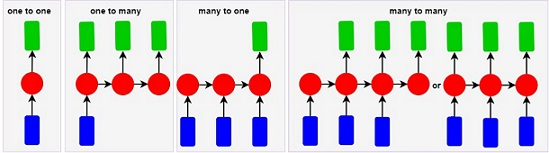   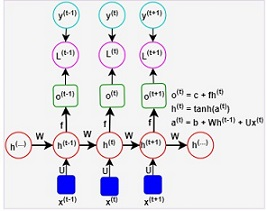

==================================== Importing Libraries =================================

In [4]:
import os
import sys
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from darts.metrics import mae
import matplotlib.pyplot as plt
from darts.models import RNNModel
from keras import models, optimizers 
from sklearn import preprocessing, metrics
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from darts import utils, TimeSeries, dataprocessing
# from gluonts.dataset.util import to_pandas
# from gluonts.dataset.common import ListDataset
# from gluonts.mx import trainer, DeepAREstimator
# from gluonts.evaluation import make_evaluation_predictions

========================================= Functions ==================================

In [5]:
# =============================================== Preparing data =====================================================
def prepare_data(data):  
     # -------------------------------------------- Step 1.1: Check type data ----------------------------------------     
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    return data

# ============================================= Sequences data =======================================================
def sequences_data(data, x_steps=6, y_steps=2, train_size=0.7, nfeatures=1):
    # !============================================= Step 1: Split data ==============================================
    # -------------------------------------------- Step 1.1: Check type data -----------------------------------------    
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # --------------------------------------------- Step 1.3: Data Splitting -----------------------------------------   
    n = math.floor(data.shape[0] * train_size)
    dat_train = data.iloc[0:n,:]
    data_train = dat_train.values.reshape(-1,1)
    
    dat_test = data.iloc[data_train.shape[0]-x_steps:,:]
    data_test = dat_test.values.reshape(-1,1)
    # !============================================== Step 2: Scaling ================================================
    mod = preprocessing.MinMaxScaler(feature_range=(0, 1))
    data_train = mod.fit_transform(data_train)
    data_test = mod.transform(data_test)
    # !============================================== Step 3: Sequences ==============================================
    # --------------------------------------------- Step 3.1: Sequences x_train --------------------------------------
    x_train = []
    y_train = []
    for i in range(x_steps, len(data_train)-y_steps+1):
        x_train.append(data_train[i-x_steps:i, 0])
        y_train.append(data_train[i:i+y_steps, 0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], nfeatures))
    # -------------------------------------------- Step 3.2: Sequences x_test ----------------------------------------
    x_test = []
    y_test = []
    for i in range(x_steps, len(data.iloc[n:,:])+x_steps-y_steps+1):
        x_test.append(data_test[i-x_steps:i, 0])
        y_test.append(data_test[i:i+y_steps, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, mod

# ============================================= Plot prediction ======================================================
def plot_prediction(y_train, y_test, pred_train, pred_test, mod, axs, name=None): 

    if name == "RNN":                                   # Plot the data only once
        axs[0].plot(range(0, len(y_train)), mod.inverse_transform(y_train[:,0].reshape(-1,1)), label='Data')
        axs[1].plot(range(len(y_train)+1, len(y_train)+len(y_test)+1), mod.inverse_transform(y_test[:,0].reshape(-1,1)), label='Data')  
        
    r2_tr = metrics.r2_score(y_train, pred_train)
    r2_te = metrics.r2_score(y_test, pred_test)
    axs[0].plot(range(0, len(y_train)), mod.inverse_transform(pred_train[:,0].reshape(-1,1)), 
                label=f' $R^2_{{{name}}}:${np.round(r2_tr, 2)}')
    axs[0].legend(fontsize=10, ncol=2, loc='best', labelcolor='linecolor', handlelength=0, handletextpad=0, columnspacing=0, title='Train')

    axs[1].plot(range(len(y_train)+1, len(y_train)+len(y_test)+1), mod.inverse_transform(pred_test[:,0].reshape(-1,1)),
                label=f' $R^2_{{{name}}}:${np.round(r2_te, 2)}')
    axs[1].legend(fontsize=10, ncol=2, loc='best', labelcolor='linecolor', handlelength=0, handletextpad=0, columnspacing=0, title='Test')
    axs[0].autoscale(enable=True, axis="x",tight=True)
    axs[1].autoscale(enable=True, axis="x",tight=True)
    plt.subplots_adjust(wspace=0.035, hspace=0.2)
    
# ====================================== Plot loss for train & test ==================================================   
def plot_loss(train_model, axs, title=None):
    # _, axs = plt.subplots(nrows=1, sharey='row', figsize=(4, 3))
    axs.plot(train_model.history["loss"], label='training loss')
    axs.plot(train_model.history["val_loss"], label='validation loss',)
    axs.legend(fontsize=10, ncol=1, loc='best', labelcolor='linecolor', handlelength=0)
    axs.autoscale(enable=True, axis="x",tight=True)
    axs.set_xlabel('Epochs', fontsize=10)
    axs.set_title(title, fontsize=10)
    plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
    axs.grid(axis='y', linestyle='--', alpha=0.25)
    plt.subplots_adjust(wspace=0.035, hspace=0.2)

*Step 1.1: Load Data*

In [6]:
data = sm.datasets.sunspots.load_pandas()  
data = data.data["SUNACTIVITY"]

In [7]:
data = prepare_data(data)
print(f"{data = }")

data =      SUNACTIVITY
0            5.0
1           11.0
2           16.0
3           23.0
4           36.0
..           ...
304         40.4
305         29.8
306         15.2
307          7.5
308          2.9

[309 rows x 1 columns]


*Step 1.2: Plot data*

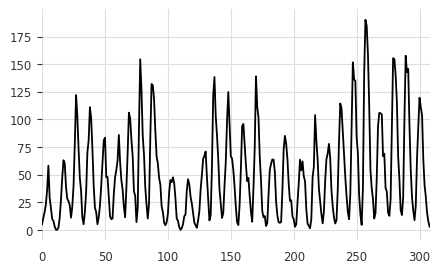

In [8]:
_, axs = plt.subplots(nrows=1,sharey='row', figsize=(5,3))
axs.plot(data)
axs.set_xlabel('', fontsize=10)
axs.set_title(f"", fontsize=10)
axs.set_ylabel('', fontsize=10)
axs.autoscale(enable=True, axis="x",tight=True)

*Step 2: Creating sequences*

In [9]:
x_steps = 6
y_steps = 2
train_size = 0.6
x_train, y_train, x_test, y_test, mod = sequences_data(data, x_steps, y_steps, train_size=0.6, nfeatures=1)

*Step 3: Creating the Simple [RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) Model using:*<br/>
[Sequential model](https://keras.io/guides/sequential_model/)<br/>
[Dense layer](https://keras.io/api/layers/core_layers/dense/)<br/>
[Activation functions](https://keras.io/api/layers/activations/)<br/>
[Model compile](https://keras.io/api/models/model_training_apis/)<br/>
[Metrics](https://keras.io/api/metrics/regression_metrics/)<br/>
[Fit method](https://keras.io/api/models/model_training_apis/)

*inputs $\Rightarrow$ Preparing 3-Dimensional Input for Sequential Model, with shape [batch, timesteps, feature].*<br/>

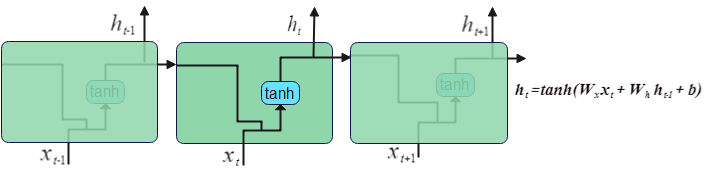

**Disadvantages of RNNs:**<Br/>
The RNN has issues with *`vanishing gradient descent`*, where the gradients used to update weights become very small and prevent the network from learning new weights. This problem worsens with more layers. Also, RNNs tend to lose information over long sequences as they only store the latest information, resulting in a short-term memory and not a long-term memory. Moreover, as the RNN uses backpropagation in time to update weights, the network also suffers from *`exploding gradients`* and, if ReLu activation functions are used, from dead ReLu units. The first might lead to convergence issues while the latter might stop the learn

In [10]:
# ================================================= Step 3.1: Building the network =================================================
methods = "Method 1"
if methods == "Method 1":                                                       # define model
    rnn_model = models.Sequential([SimpleRNN(50, return_sequences=True),                      
                                SimpleRNN(50),
                                Dense(y_steps)])
else:
    rnn_model = models.Sequential()                                             # define model
    rnn_model.add(SimpleRNN(50, dropout=0.2, return_sequences=True, 
                            input_shape=(x_train.shape[1], x_train.shape[2])))  # input_shape-->(n_timesteps,n_feature)
    rnn_model.add(SimpleRNN(50, dropout=0.2, activation="tanh", return_sequences=True))
    rnn_model.add(SimpleRNN(50, dropout=0.2, activation="sigmoid", return_sequences=True))
    rnn_model.add(SimpleRNN(40, dropout=0.3, activation="tanh"))
    rnn_model.add(Dense(y_train.shape[1]))                                      # n_outputs-->y_train.shape[1]
    print(f"rnn_model.summary:")
    print(f"{rnn_model.summary()}")
    
print(f"\nrnn_model.layers:\n{rnn_model.layers}")                               # Print the model parameters
# ?==================================================== Step 3.2: Compile model =====================================================
rnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", 
                  metrics=["mean_absolute_error"])                              # Regression:mean_squared_error
# !================================================= Step 3.3: Training the Model ===================================================
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
rnn_train_model = rnn_model.fit(x_train, y_train, epochs=100, validation_split=0.15, callbacks=[stop_early])
# train_model = rnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[stop_early])
# =========================================== Step 3.4: Predicting for train & test data ===========================================
rnn_pred_train = rnn_model.predict(x_train)
rnn_pred_test = rnn_model.predict(x_test)


rnn_model.layers:
[<keras.src.layers.rnn.simple_rnn.SimpleRNN object at 0x000002FB3B0DAFD0>, <keras.src.layers.rnn.simple_rnn.SimpleRNN object at 0x000002FB3B58CD90>, <keras.src.layers.core.dense.Dense object at 0x000002FB3B513450>]
Epoch 1/100
5/5 [==============================] - 11s 196ms/step - loss: 0.1180 - mean_absolute_error: 0.2708 - val_loss: 0.0706 - val_mean_absolute_error: 0.1996
Epoch 2/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0575 - mean_absolute_error: 0.1835 - val_loss: 0.0518 - val_mean_absolute_error: 0.1736
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0373 - mean_absolute_error: 0.1499 - val_loss: 0.0500 - val_mean_absolute_error: 0.1655
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0425 - mean_absolute_error: 0.1506 - val_loss: 0.0363 - val_mean_absolute_error: 0.1509
Epoch 5/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0344 - mean_absolute_error: 0.1461 - val_l

*Long-Short-Term-Memory [(LSTM)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)*<br/>
LSTMs are a type of RNNs that solve the problem of vanishing gradients, which is the loss of information from the distant past, that simple RNNs face.

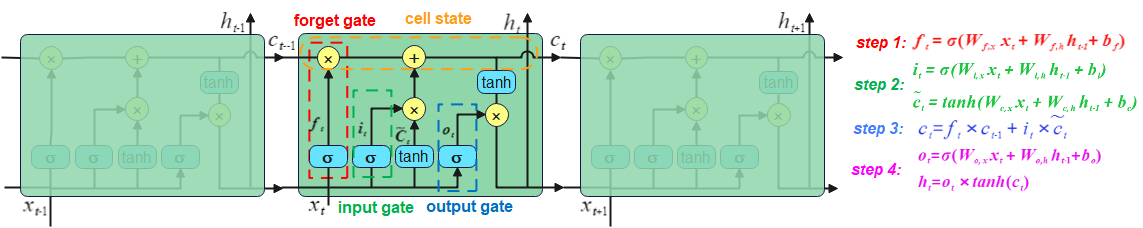

The *`forget gate`*, which utilizes a sigmoid function, determines the relevance of the cell state and determines how much of the long-term memory should be retained.<br/>
The *`input gate`*, through a sigmoid layer, determines the information that will be incorporated into the cell state and consequently the long-term memory.<br/>
The *`output gate`* controls the selection of cell state components that contribute to the output, and therefore, it is responsible for short-term memory.<br/>

**Disadvantages of LSTMs**<br/>
- LSTMs are more computationally intensive, resulting in lengthier training periods.
-  LSTM also uses the backpropagation in time algorithm to update the weights, the LSTM suffers from the disadvantages of the backpropagation (e.g., dead ReLu elements, exploding gradients).

In [11]:
# ================================================= Step 3.1: Building the network ==================================================
methods = "Method 1"
if methods == "Method 1":                                                       # define model
    lstm_model = models.Sequential([LSTM(50, return_sequences=True),
                    LSTM(50),
                    Dense(y_steps)])
else:
    lstm_model = models.Sequential()                                            # define model
    lstm_model.add(LSTM(100, return_sequences=True, dropout=0.2, 
                        input_shape=(x_train.shape[1], x_train.shape[2])))      # input_shape-->(n_timesteps,n_feature)
    lstm_model.add(LSTM(70, activation="relu", dropout=0.1, return_sequences=True))
    lstm_model.add(LSTM(100, activation="tanh", dropout=0))
    lstm_model.add(Dense(y_train.shape[1], activation="tanh"))                  # n_outputs-->y_train.shape[1]
    print(f"lstm_model.summary:")
    print(f"{lstm_model.summary()}")
    
print(f"\n lstm_model.layers:\n{lstm_model.layers}")                             # Print the model parameters                                    
# ?==================================================== Step 3.2: Compile model =====================================================
lstm_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", 
                  metrics=["mean_absolute_error"])                              # Regression:mean_squared_error   
# !================================================= Step 3.3: Training the Model ===================================================
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lstm_train_model = lstm_model.fit(x_train, y_train, epochs=100, validation_split=0.15, callbacks=[stop_early])
# train_model = rnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[stop_early])
# =========================================== Step 3.4: Predicting for train & test data ============================================
lstm_pred_train = lstm_model.predict(x_train)
lstm_pred_test = lstm_model.predict(x_test)    


 lstm_model.layers:
[<keras.src.layers.rnn.lstm.LSTM object at 0x000002FB3EACC650>, <keras.src.layers.rnn.lstm.LSTM object at 0x000002FB40B347D0>, <keras.src.layers.core.dense.Dense object at 0x000002FB3B466890>]
Epoch 1/100
5/5 [==============================] - 10s 375ms/step - loss: 0.1145 - mean_absolute_error: 0.2506 - val_loss: 0.1183 - val_mean_absolute_error: 0.2696
Epoch 2/100
5/5 [==============================] - 0s 34ms/step - loss: 0.0836 - mean_absolute_error: 0.2097 - val_loss: 0.0863 - val_mean_absolute_error: 0.2379
Epoch 3/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0667 - mean_absolute_error: 0.2046 - val_loss: 0.0763 - val_mean_absolute_error: 0.2348
Epoch 4/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0652 - mean_absolute_error: 0.2156 - val_loss: 0.0725 - val_mean_absolute_error: 0.2281
Epoch 5/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0607 - mean_absolute_error: 0.2050 - val_loss: 0.0689 - val_me

*Gated Recurrent Unit [(GRU)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)*<br/>
[Article](https://arxiv.org/pdf/1406.1078.pdf)<br/>
GRU resolves vanishing gradient issue in basic RNNs. GRUs have a simpler architecture compared to LSTMs as they use fewer gates and do not have a separate internal memory or cell state. Instead, they solely rely on the hidden state as a memory.

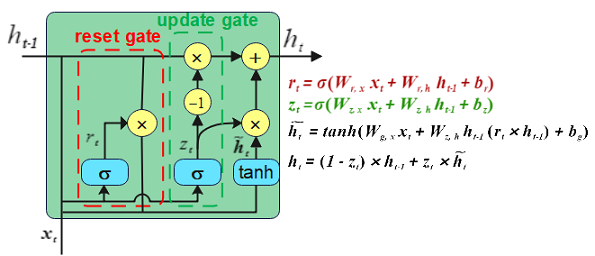

The *`reset gate`* controls short-term memory by determining which past information is retained and which is ignored. The vector *r's* values are limited to a range of *0 to 1* through a *sigmoid function*. These values are determined by the hidden state *h* from the previous time step and the current *input x*.<br/>
The `update gate` is like the LSTM's forget gate but is in charge of long-term memory.

**Disadvantages of GRUs**
- The GRU may not be able to take into account observations from as far back in time as the LSTM due to the absence of a distinct hidden and cell state.
- The GRU may experience issues with backpropagation in time and weight updates, such as dead ReLu elements and exploding gradients.

In [12]:
# ================================================= Step 3.1: Building the network ==================================================
methods = "Method 1"
if methods == "Method 1":                                                       # define model
    gru_model = models.Sequential([GRU(50, return_sequences=True),
                    GRU(50),
                    Dense(y_steps)]) 
else:
    gru_model = models.Sequential()                                             # define model
    gru_model.add(GRU(100, return_sequences=True, dropout=0.2, 
                        input_shape=(x_train.shape[1], x_train.shape[2])))      # input_shape-->(n_timesteps,n_feature)
    gru_model.add(GRU(70, activation="tanh", dropout=0.1, return_sequences=True))
    gru_model.add(GRU(100, activation="relu", dropout=0.1))
    gru_model.add(Dense(y_train.shape[1]))                                      # n_outputs-->y_train.shape[1]
    print(f"gru_model.summary:")
    print(f"{gru_model.summary()}")
    
print(f"\n gru_model.layers:\n{gru_model.layers}")                             # Print the model parameters                                    
# ?==================================================== Step 3.2: Compile model =====================================================
gru_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", 
                  metrics=["mean_absolute_error"])                              # Regression:mean_squared_error   
# !================================================= Step 3.3: Training the Model ===================================================
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
gru_train_model = gru_model.fit(x_train, y_train, epochs=100, validation_split=0.15, callbacks=[stop_early])
# train_model = rnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[stop_early])
# =========================================== Step 3.4: Predicting for train & test data ===========================================
gru_pred_train = gru_model.predict(x_train)
gru_pred_test = gru_model.predict(x_test)    


 gru_model.layers:
[<keras.src.layers.rnn.gru.GRU object at 0x000002FB40B599D0>, <keras.src.layers.rnn.gru.GRU object at 0x000002FB3D6E02D0>, <keras.src.layers.core.dense.Dense object at 0x000002FB41C8AD10>]
Epoch 1/100
5/5 [==============================] - 10s 335ms/step - loss: 0.0948 - mean_absolute_error: 0.2252 - val_loss: 0.0821 - val_mean_absolute_error: 0.2265
Epoch 2/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0596 - mean_absolute_error: 0.1914 - val_loss: 0.0646 - val_mean_absolute_error: 0.2137
Epoch 3/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0579 - mean_absolute_error: 0.2030 - val_loss: 0.0622 - val_mean_absolute_error: 0.2104
Epoch 4/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0539 - mean_absolute_error: 0.1926 - val_loss: 0.0584 - val_mean_absolute_error: 0.1986
Epoch 5/100
5/5 [==============================] - 0s 21ms/step - loss: 0.0505 - mean_absolute_error: 0.1807 - val_loss: 0.0571 - val_mean_ab

*Plot of Training and Test Loss Functions*
[1](https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4)

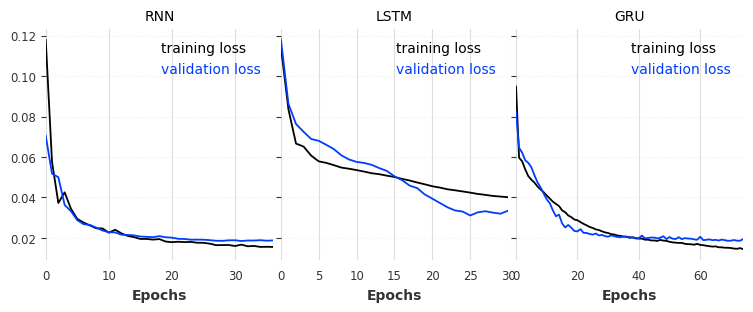

In [13]:
_, axs = plt.subplots(nrows=1, ncols=3, sharey='row', figsize=(9, 3))
plot_loss(rnn_train_model, axs[0], title="RNN")
plot_loss(lstm_train_model, axs[1], title="LSTM")
plot_loss(gru_train_model, axs[2], title="GRU")

*Plot of actuals and predictions for train & test data*

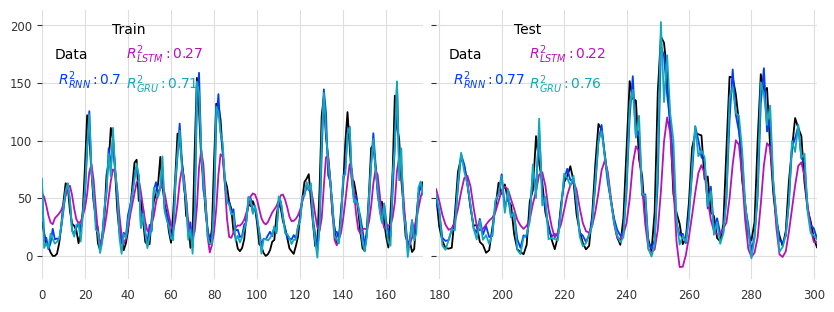

In [14]:
_, axs = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10, 3.5))
plot_prediction(y_train, y_test, rnn_pred_train, rnn_pred_test, mod, axs, name='RNN')
plot_prediction(y_train, y_test, lstm_pred_train, lstm_pred_test, mod, axs, name='LSTM')
plot_prediction(y_train, y_test, gru_pred_train, gru_pred_test, mod, axs, name='GRU')

Data Analysis in Real-Times[ (Darts)](https://pypi.org/project/darts/)<br/>
[RNNModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html#darts.models.forecasting.rnn_model.RNNModel)<br/>

`Covariates` refer to additional variables or features that are included alongside the target variable(s) in a time series forecasting model. These covariates can help improve the forecasting accuracy by providing additional information that may influence the target variable(s) over time.

In [15]:
# ==================================================== Step 3.1: Data split ========================================================
train_size = 0.7                                # Proportion of data to be used for training (70% in this case)
data_darts = data 
data_darts.index= pd.to_datetime(range(0, data_darts.shape[0]), 
                                 unit='D', origin=pd.Timestamp('1960-01-01')) # Creating a date-based index for the data
data_darts = data_darts.groupby(data_darts.index.astype(str).str.split(" ").str[0]).mean().reset_index()  
data_darts = utils.missing_values.fill_missing_values(TimeSeries.from_dataframe(data_darts,"index",
                                ["SUNACTIVITY"]),"auto") # Filling missing values in the "SUNACTIVITY" column
data_darts = data_darts.astype(np.float32)               # Converting data type to float32 for numerical computations

data_cov = utils.timeseries_generation.datetime_attribute_timeseries(data_darts, attribute="day",
                         one_hot=True, dtype=np.float32) # Generating one-hot encoded time series for the "day" attribute
# ==================================================== Step 3.2: Data scale ========================================================
mod_darts = dataprocessing.transformers.Scaler()
data_darts = mod_darts.fit_transform(data_darts)
x_train_darts, val_train_darts = data_darts.split_after(train_size) # Splitting the scaled data into training and validation sets

data_cov = mod_darts.fit_transform(data_cov)
train_cov, val_cov = data_cov.split_after(train_size)
# ================================================= Step 3.3: Building the network =================================================
rnn_darts_model = models.RNNModel(model="LSTM",        # Size for feature maps for each hidden RNN layer
                n_rnn_layers=2, dropout=0, n_epochs=20, 
                optimizer_kwargs={"lr":1e-2}, hidden_dim=50, 
                input_chunk_length=20,           # Number of past time steps that are fed to the forecasting module at prediction time.
                training_length=50,              # The length of both input (target and covariates) and output (target) time series used during training
                likelihood=utils.likelihood_models.GaussianLikelihood())   

                            

AttributeError: module 'keras.models' has no attribute 'RNNModel'

*[DeepAR](https://www.selvai.com/probabilistic_time_series_modeling.html)*

DeepAR is a recurrent neural network based on LSTM architecture, which undergoes training using the historical data of all the time series present in the dataset.


pip install gluonts <br/>
pip install mxnet gluonts ujson


In [ ]:
# ==================================================== Step 3.1: Data split ========================================================
data.index= pd.to_datetime(range(0, data.shape[0]), unit='D', origin=pd.Timestamp('1960-01-01'))
data_train_size = math.floor(data.shape[0] * 0.7)
x_train_ar = ListDataset([{"start": data.index[0], "target": data["SUNACTIVITY"].iloc[:data_train_size].values}], freq="D")

x_test_ar = ListDataset([{"start":data.index[0], "target":data.SUNACTIVITY}], freq="D")
# ?================================================= Step 3.2: Building te model ===================================================
callbacks = [trainer.learning_rate_scheduler.LearningRateReduction(objective="min", patience=10, base_lr=1e-3, decay_factor=0.5),
             trainer.model_averaging.ModelAveraging(avg_strategy=trainer.model_averaging.SelectNBestMean(num_models=2))]

deepAR_model = DeepAREstimator(freq="D",                   # Frequency of the time series data (Daily data)                   
                               prediction_length=5,        # Number of time steps to predict into the future
                               context_length=10,          # Number of time steps to use as context for prediction
                               num_layers=4,               # Number of RNN layers in the model
                               num_cells=100,              # Number of RNN cells in each layer
                               dropout_rate=0.05,          # Dropout rate for regularization
                               cell_type="lstm",           # RNN cell type, in this case, LSTM or GRU
                               trainer=trainer.Trainer(epochs=10, callbacks=callbacks)) # Trainer configuration for model training             
# !================================================== Step 3.3: Training the Model =================================================
deepAR_train_model = deepAR_model.train(x_train_ar)
# ============================================ Step 3.4: Predicting for train & test data ==========================================
ar_pred_train, ts_it = make_evaluation_predictions(dataset=x_test_ar, predictor=deepAR_train_model, 
                                                 num_samples=100)   # number of sample paths we want for evaluation
forecasts = list(ar_pred_train)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]      
forecast_entry.mean                                                 # a.quantile(0.5)                                 

In [ ]:

 past_covariates=None, future_covariates=None, val_series=None, val_past_covariates=None, val_future_covariates=None, trainer=None, verbose=None

# !================================================= Step 3.4: Training the Model ==================================================
rnn_darts_train_model = rnn_darts_model.fit(series=x_train_darts, future_covariates=train_cov)
# =========================================== Step 3.5: Predicting for train & test data ===========================================
pred = rnn_darts_model.predict(n=100, num_samples=5, past_covariates=None, future_covariates=val_cov)
val_train_darts.slice_intersect(pred).plot(label="target")
pred.plot(label="Prediction")
mae(val_train_darts, pred)

![Historical Forecasts.bmp](<attachment:Historical Forecasts.bmp>)
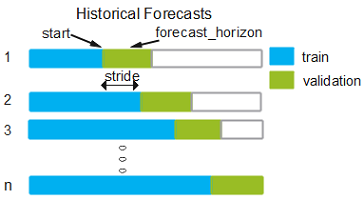

In [ ]:
hist_forecast_energy = rnn_darts_model.historical_forecasts(
                       series=data_darts,           # Time series data for forecasting
                       future_covariates=data_cov,  # Future covariates or additional features
                       num_samples=50,              # Number of forecast samples to generate
                       start=0.7,                   # Starting point for making forecasts (70% of data)
                       forecast_horizon=30,         # Number of time steps to forecast into the future
                       stride=5)                    # Step size for generating forecasts

In [ ]:
plt.figure(figsize=(10, 6))
data.plot(label="actual")
hist_forecast_energy.plot(label="Historical Forecast (H=30)", low_quantile=0.01, high_quantile=0.99)
plt.legend()